### Load the data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_train=pd.read_csv("training_data.csv")
text_train=df_train['text']

In [3]:
star_train=df_train.stars

In [4]:
df_test=pd.read_csv("test_data.csv")
text_test=df_test.text

In [5]:
df_sub=pd.read_csv("sample_submission.csv",names=np.array(['id','stars']))
star_test=df_sub.stars

### Create the rating matrix

In [6]:
df_train.head()

,review_id,business_id,user_id,text,date,stars
0,3223,2055,2533,"Sometimes things happen, and when they do this...",2010-12-30,5
1,9938,4165,6371,I know Kerrie through my networking and we ben...,2011-04-26,5
2,7123,869,4929,Love their pizza!!!\nVery fresh. Their cannoli...,2012-09-28,5
3,3601,1603,2789,Being from NJ I am always on the prowl for my ...,2009-06-07,4
4,3948,2347,1245,We have tried this spot a few times and each v...,2011-02-20,4


In [7]:
n_business=max(df_train.business_id.unique())
n_user=max(df_train.user_id.unique())
print(n_business,n_user)

4174 6402


In [8]:
user_star_matrix=np.zeros((n_user,n_business)) #rating from 1 to 5, and 0 means no rating
for i in df_train.itertuples():
    user_star_matrix[i[3]-1,i[2]-1]=i[6] #type is ndarray, index starts from 0, rows:user coln:business value:star

### Text processing

#### tf-idf (ngram_range=(1, 1)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
tfidf=TfidfVectorizer(ngram_range=(1, 1),stop_words='english')
tfidf.fit(text_train)
td_train=tfidf.transform(text_train)
td_test=tfidf.transform(text_test)

In [8]:
td_train=td_train.toarray()
td_test=td_test.toarray()

#### sentiment-analysis

reference:https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/negative-words.txt

In [9]:
positive_words=pd.read_csv("positive-words.txt")
negative_words=pd.read_csv("negative-words.txt")

In [12]:
train_pos=np.zeros((len(td_train),1))
train_neg=np.zeros((len(td_train),1))
test_pos=np.zeros((len(td_test),1))
test_neg=np.zeros((len(td_test),1))

for i in range(len(td_train)):
    n=0
    for word in tfidf.get_feature_names():
        for pos in positive_words:
            if word==pos:
                n+=1
                break
    train_pos[i]=n

for i in range(len(td_train)):
    n=0
    for word in tfidf.get_feature_names():
        for neg in negative_words:
            if word==neg:
                n+=1
                break
    train_neg[i]=n
    
for i in range(len(td_test)):
    n=0
    for word in tfidf.get_feature_names():
        for p in positive_words:
            if word==p:
                n+=1
                break
    test_pos[i]=n  
    
for i in range(len(td_test)):
    n=0
    for word in tfidf.get_feature_names():
        for neg in negative_words:
            if word==neg:
                n+=1
                break
    train_neg[i]=n

#### #weight of negative-word=-1, weight od positive word=1

In [138]:
""""
Wneg=np.zeros((td_train.shape[1]))
for i in range(len(tfidf.get_feature_names())):
    word=tfidf.get_feature_names()[i]
    for j in np.array(negative_words):
        if word==j:
            Wneg[i]=-1  
"""

In [144]:
#W_td_train=np.multiply(td_train,Wneg)

In [145]:
#W_td_test=np.multiply(td_test,Wneg)

### Extracting features

In [13]:
train_business_id=np.array(df_train.business_id)
train_business_id=train_business_id[:,np.newaxis]

train_user_id=np.array(df_train.user_id)
train_user_id=train_user_id[:,np.newaxis]

test_business_id=np.array(df_test.business_id)
test_business_id=test_business_id[:,np.newaxis]

test_user_id=np.array(df_test.user_id)
test_user_id=test_user_id[:,np.newaxis]

#### PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [15]:
#reduce text dimension 
pca.fit(td_train)
td_pca_train=pca.transform(td_train)
td_pca_test=pca.transform(td_test)

In [16]:
#combine all the features
train_feature=np.concatenate((td_pca_train,train_business_id,train_user_id,train_pos,train_neg),axis=1)
test_feature=np.concatenate((td_pca_test,test_user_id,test_business_id,test_pos,test_neg),axis=1)

In [17]:
#extract features
pca.fit(train_feature)
train=pca.transform(train_feature)
test=pca.transform(test_feature)

### Create the text similarity matrix for collaborative filtering

#### by cosine similarity measure

In [18]:
from sklearn.metrics.pairwise import linear_kernel

In [19]:
cos_sim=linear_kernel(test,train)

In [ ]:
#等等!!!先確定cos_sim的shape為多少 調整下面的rating prediction

In [20]:
cos_sim.shape

(2003, 7997)

### Rating predict

#### collaborative filtering: Rtest,text=sum(cos_sim[test,train]* Rtrain,text)/sum(cos_sim[test,train]

In [21]:
star_pred_CF=np.zeros((len(df_test)))

In [22]:
upper=0
lower=0

for i in range(len(df_test)):
    sim=cos_sim[i]
    sort_ind_sim=np.argsort(-sim)[:99]
    sort_sim=np.sort(sim)[:-100:-1]
    upper=sum(sort_sim*star_train[sort_ind_sim])
    lower=sum(sort_sim)

    if lower!=0:
        R=upper/lower
        if R<0:
            R=0
        if R>5:
            R=5
        star_pred_CF[i]=(upper/lower)

In [23]:
import sklearn.metrics #inclusding the module of Rooted Mean Square Error(rmse)
import math

rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_CF))
rmse

1.628228706957193

#### Linear regression

In [24]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()

LR.fit(train,star_train)
star_pred_LR=LR.predict(test)

print('score:',LR.score(test,star_test))

import sklearn.metrics #inclusding the module of Rooted Mean Square Error(rmse)
import math

rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_LR))
print('rmse:',rmse)

score: -0.2182224674125397
rmse: 1.581057995543768


#### KNeighborsRegressor

In [25]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors=[1,3,5,10,20,50]

for n in n_neighbors:
    knr=KNeighborsRegressor(n_neighbors=n)
    knr.fit(train,star_train)
    print(n,knr.score(test,star_test))

1 -0.8079953753933811
3 -0.4262506917717668
5 -0.33197508309764134
10 -0.292803066486373
20 -0.25816442005839324
50 -0.22198161760168644


In [26]:
KNR=KNeighborsRegressor(n_neighbors=50)
KNR.fit(train,star_train)
star_pred_KNR=KNR.predict(test)

print('score:',KNR.score(test,star_test))

rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_KNR))
print('rmse:',rmse)

score: -0.22198161760168644
rmse: 1.5834955045659362


In [27]:
for n in n_neighbors:
    knr=KNeighborsRegressor(n_neighbors=n)
    knr.fit(td_train,star_train)
    print(n,knr.score(td_test,star_test))

1 -0.2525313137565772
3 -0.2584517220642846
5 -0.3308364182669534
10 -0.36445866035087393
20 -0.3674075102970138
50 -0.3579258385196984


#### svm (classifier)

In [28]:
from sklearn import svm
clf=svm.SVC() #default: kernel='rbf'
clf.fit(train,star_train)
star_pred_svm=clf.predict(test)
print('score:',clf.score(test,star_test))
rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_svm))
print('rmse:',rmse)

score: 0.2076884672990514
rmse: 1.7375187891605577


#### svr (regression)

In [31]:
#splitting the data simply into three parts, training, validation and testing because training set is very large
from sklearn.model_selection import train_test_split, ShuffleSplit
X_train, X_test, y_train, y_test = train_test_split(train, star_train, random_state=1)

In [32]:
#find the best C and gamma in an SVM
from sklearn.svm import SVR
#from sklearn.model_selection import KFold
#cv=KFold(shuffle=True)
single_split_cv = ShuffleSplit(n_splits=1)

from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.001,0.01,0.1,1,10],'gamma':[0.001,0.01,0.1,1]}

grid=GridSearchCV(SVR(),param_grid=param_grid,cv=single_split_cv,verbose=3)
grid.fit(X_train,y_train)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] .. C=0.001, gamma=0.001, score=-0.0731570787739082, total=   2.2s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] .. C=0.001, gamma=0.01, score=-0.07345020873615282, total=   2.2s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


[CV] ... C=0.001, gamma=0.1, score=-0.07363097950452269, total=   2.3s
[CV] C=0.001, gamma=1 ................................................
[CV] ..... C=0.001, gamma=1, score=-0.07362999731893871, total=   2.2s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ... C=0.01, gamma=0.001, score=-0.0706683710734266, total=   2.3s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ... C=0.01, gamma=0.01, score=-0.07318649579304239, total=   2.3s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .... C=0.01, gamma=0.1, score=-0.07368589850182561, total=   2.7s
[CV] C=0.01, gamma=1 .................................................
[CV] ...... C=0.01, gamma=1, score=-0.07383704731365737, total=   3.2s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ... C=0.1, gamma=0.001, score=-0.06251025256130549, total=   2.4s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [33]:
print(grid.best_score_)
print(grid.best_params_)

-0.008250254089764875
{'C': 10, 'gamma': 1}


In [34]:
svr=SVR(gamma=1,C=10,epsilon=0.2)
svr.fit(train,star_train)
star_pred_svr=svr.predict(test)
print(svr.score(test,star_test))
rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_svr))
print('rmse:',rmse)

-0.227524756822318
rmse: 1.5870829580447416


#### DecisionTreeClassifier

In [35]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(train, star_train)
dtc.score(test, star_test)

0.19021467798302547

In [37]:
star_pred_dtc=dtc.predict(test)
star_pred_dtc

array([1, 5, 5, ..., 4, 4, 3], dtype=int64)

### Visualize the text data

#### predicted rating v.s true rating

In [20]:
color={1:'y',2:'g',3:'b',4:'r',5:'k'}
df_train['color']=df_train['stars'].map(color)
df_train.head()

,review_id,business_id,user_id,text,date,stars,color
0,3223,2055,2533,"Sometimes things happen, and when they do this...",2010-12-30,5,k
1,9938,4165,6371,I know Kerrie through my networking and we ben...,2011-04-26,5,k
2,7123,869,4929,Love their pizza!!!\nVery fresh. Their cannoli...,2012-09-28,5,k
3,3601,1603,2789,Being from NJ I am always on the prowl for my ...,2009-06-07,4,r
4,3948,2347,1245,We have tried this spot a few times and each v...,2011-02-20,4,r


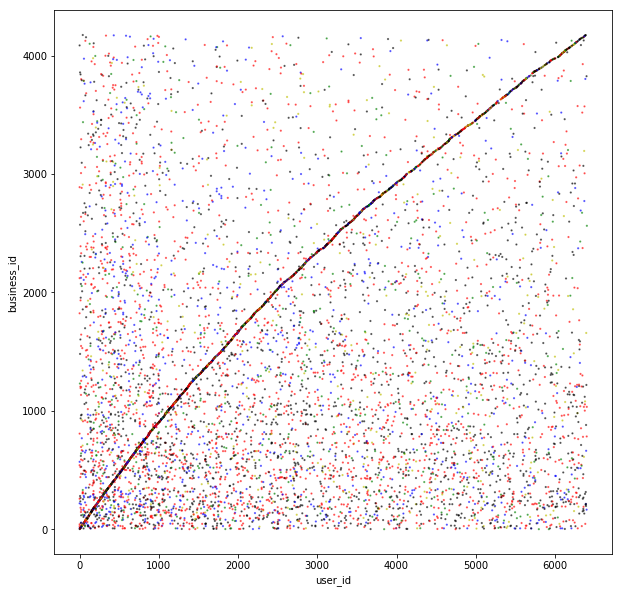

In [21]:
df_train.plot.scatter(x='user_id',y='business_id',c=df_train['color'],s=1.5,figsize=(10,10),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'

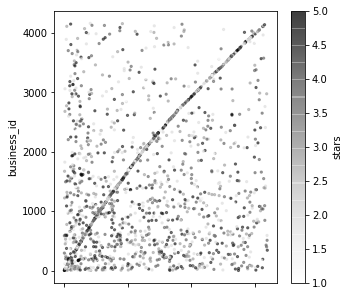

In [117]:
df_sub.plot.scatter(x='user_id',y='business_id',c='stars',s=5,figsize=(5,5),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'

In [55]:
df_test['stars']=star_pred_test

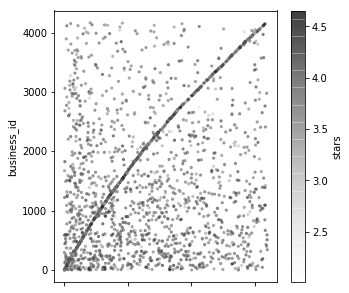

In [118]:
df_test.plot.scatter(x='user_id',y='business_id',c='stars',s=5,figsize=(5,5),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'

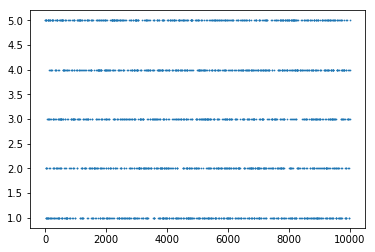

In [113]:
plt.scatter(df_sub.id,df_sub.stars,s=0.5)
#plt.plot()

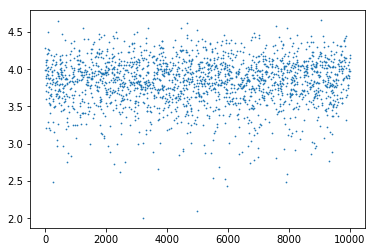

In [114]:
plt.scatter(df_test.review_id,df_test.stars,s=0.5)

In [101]:
df_test['size']=4


df_test.head()

,review_id,business_id,user_id,text,date,stars,size,color
0,2713,668,2196,Ticoz is not a bad place. The menu is eclecti...,2009-01-04,3.728880,4,w
1,4734,1014,3521,"Wow!\nBeing a Phoenix native, we have enjoyed ...",2010-10-05,4.125883,4,w
2,5598,2939,3028,Jodi is fantastic! Extraordinary! After too ...,2011-04-29,4.037738,4,w
3,9545,4077,6200,T&S Glass did a wonderful job replacing my car...,2007-10-02,3.489950,4,w
4,1471,1126,1268,My experience was on a random Saturday afterno...,2010-08-16,3.752052,4,w


In [102]:
df_sub['size']=8

In [103]:
df_pred=pd.DataFrame()

df_pred=pd.concat([df_sub,df_test])

In [96]:
df_pred

,business_id,color,date,id,review_id,size,stars,text,user_id
0,668,y,NaN,2713.0,NaN,5.0,1.000000,NaN,2196
1,1014,y,NaN,4734.0,NaN,5.0,1.000000,NaN,3521
2,2939,k,NaN,5598.0,NaN,5.0,5.000000,NaN,3028
3,4077,y,NaN,9545.0,NaN,5.0,1.000000,NaN,6200
4,1126,r,NaN,1471.0,NaN,5.0,4.000000,NaN,1268
5,1284,y,NaN,4533.0,NaN,5.0,1.000000,NaN,3196
6,3598,k,NaN,7723.0,NaN,5.0,5.000000,NaN,5252
7,404,y,NaN,2433.0,NaN,5.0,1.000000,NaN,1021
8,2200,r,NaN,9182.0,NaN,5.0,4.000000,NaN,1231
9,1555,k,NaN,2238.0,NaN,5.0,5.000000,NaN,1857


TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

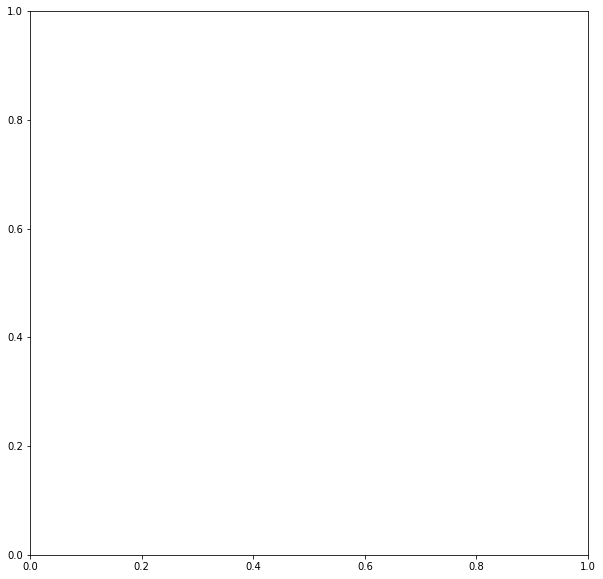

In [106]:
df_pred.plot.scatter(x='user_id',y='business_id',s='stars',figsize=(10,10))

ValueError: You passed in an invalid linestyle, `*`.  See docs of Line2D.set_linestyle for valid values.

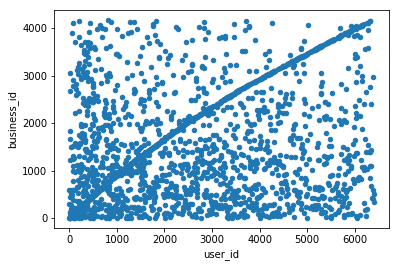

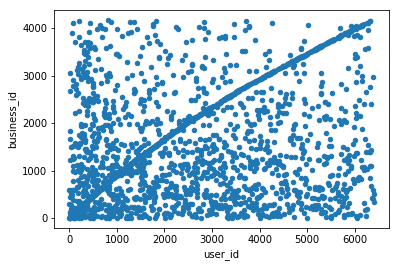

In [59]:
import matplotlib.lines as mlines

plt.figure()
p1=df_sub.plot.scatter(x='user_id',y='business_id')
p1=df_test.plot.scatter(x='user_id',y='business_id')
p1_l=mlines.Line2D([],[],linestyle='*',color=df_sub['color'],size=5,alpha=0.5)
p2_l=mlines.Line2D([],[],linestyle='+',color=df_test['color'],size=1.5)

### Train-test-split according to the line in the figure

In [32]:
user_star_matrix[6401,4173]

0.0